In [ ]:
from google.colab import drive
!pip install adversarial-robustness-toolbox
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile 
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random



# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.12.0
Keras version:2.12.0


In [ ]:
# Uncompress the Imagenette dataset 
# (Obviously, replace the path to the folder on Google drive where you saved the dataset)
tar = tarfile.open('/content/drive/MyDrive/ass1/imagenette2-160.tgz', 'r:gz')
for item in tar:
    tar.extract(item)

In [ ]:
# Function to load the images and the labels from the dataset
def load_images_and_labels(directory):

    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted 
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = directory + '/' + subfolder_name
            if subfolder_name != '.DS_Store':

                # Read the images as numpy arrays
                imagesList = listdir(sub_dir_path)
                for i in range(len(imagesList)):
                  tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                  # Resize all images to 128 x 128 pixels
                  resized_img = cv2.resize(tmp_img, (128, 128)) 
                  img_arr = np.array(resized_img)
                  imgs_list.append(img_arr/255.)
                  labels_list.append(lab)
                lab += 1
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the training and test datasets
train_images, train_labels = load_images_and_labels('imagenette2-160/train')
test_and_val_images, test_and_val_labels = load_images_and_labels('imagenette2-160/val')

In [ ]:
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=12)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469,)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570,)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4496687819589053
Data type float64


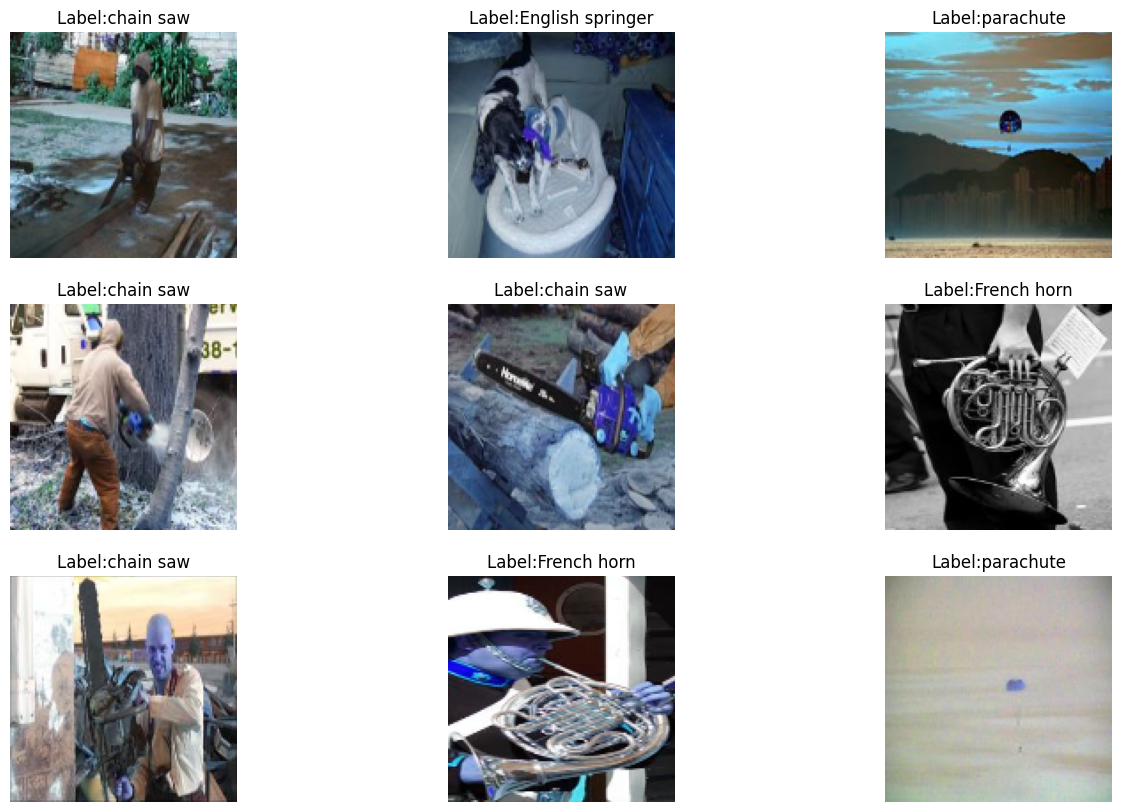

In [ ]:
# A list with the names of the image classes
label_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn',  'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [ ]:
NUM_CLASSES = 10
BATCH_SIZE = 20                             # Size of batch
HEIGHT = 128                                 # Height of input image
WIDTH = 128                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 3                             # Number of output dimension
NUM_EPOCH = 10                             # Number of epoch to train
LR = 0.01                                 # Learning rate

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)
     
# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

# If you wish to convert the labels into one-hot encoding (but you don't need to), use the following lines 
from tensorflow.keras.utils import to_categorical
train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)
test_and_val_labels_onehot = to_categorical(test_and_val_labels, NUM_CLASSES)

In [ ]:
# load ResNet50 model with imagenet pretrained in Keras API (NOT INCLUDE TOP DENSE LAYERS)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=keras.layers.Input((128,128,3)))
# Fine-tune ResNet50 model.
# Add several Dense layers on top of it and a softmax dense layer with output dense of 3 labels
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=[base_model.input], outputs=[predictions])


Instructions for updating:
Colocations handled automatically by placer.


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# SGD optimizer
optimizer = keras.optimizers.SGD(learning_rate=LR)
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# reduce lr based on val_loss
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
# compile the keras model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])#why not categorical_crossentropy why is (9000 1)

# fit the keras model on the dataset with validation for monitoring validation loss and accuracy at the end of each epoch
history = model.fit(train_images, train_labels_onehot, epochs = NUM_EPOCH, batch_size = BATCH_SIZE, validation_data = (val_images, val_labels_onehot), shuffle = True, callbacks=[callback,reduce_lr])
     

Train on 9469 samples, validate on 1570 samples
Epoch 1/10
9469/9469 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.7970

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


9469/9469 [==============================] - 64s 7ms/sample - loss: 0.6458 - accuracy: 0.7970 - val_loss: 2.5461 - val_accuracy: 0.1497 - lr: 0.0100
Epoch 2/10
9469/9469 [==============================] - 45s 5ms/sample - loss: 0.2233 - accuracy: 0.9345 - val_loss: 0.4170 - val_accuracy: 0.8732 - lr: 0.0100
Epoch 3/10
9469/9469 [==============================] - 45s 5ms/sample - loss: 0.1220 - accuracy: 0.9639 - val_loss: 0.4093 - val_accuracy: 0.8936 - lr: 0.0100
Epoch 4/10
9469/9469 [==============================] - 45s 5ms/sample - loss: 0.0703 - accuracy: 0.9794 - val_loss: 0.2373 - val_accuracy: 0.9338 - lr: 0.0100
Epoch 5/10
9469/9469 [==============================] - 45s 5ms/sample - loss: 0.0593 - accuracy: 0.9831 - val_loss: 0.2532 - val_accuracy: 0.9395 - lr: 0.0100
Epoch 6/10
9469/9469 [==============================] - 45s 5ms/sample - loss: 0.0491 - accuracy: 0.9846 - val_loss: 0.2578 - val_accuracy: 0.9376 - lr: 0.0100
Epoch 7/10
9469/9469 [=============================

In [ ]:
results = model.evaluate(test_images, test_labels_onehot)
print("test loss, test acc:", results)
results = model.evaluate(test_and_val_images, test_and_val_labels_onehot)
print("aside test loss, aside test acc:", results)

test loss, test acc: [0.20490675459817573, 0.9490446]
aside test loss, aside test acc: [0.2014446989652867, 0.94878983]


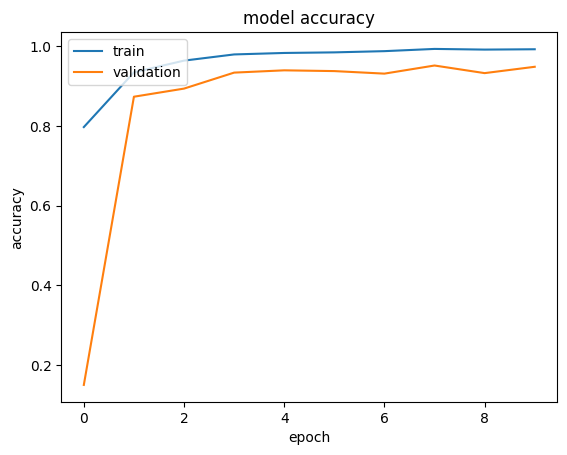

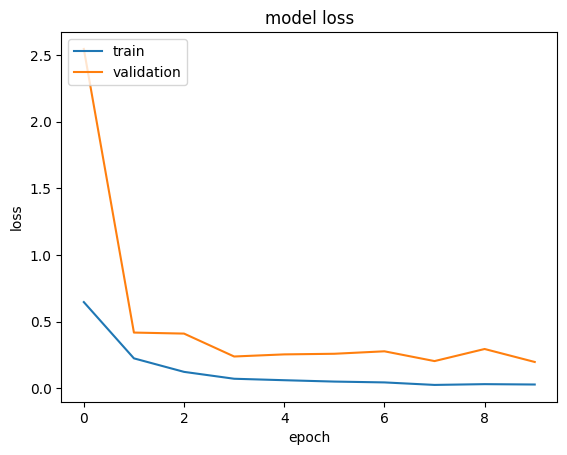

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:

PROJECT_ROOT_DIR = '/content/drive/MyDrive/ass1/'
model_save_path = PROJECT_ROOT_DIR + 'imagenette2-160_resnet50.h5'
model.save(model_save_path)


In [ ]:
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool
import sys

from art.estimators.classification import KerasClassifier
from art.utils import load_dataset





In [ ]:
min_,max_=0,1

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
epsilons = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]
fgsm_accuracies = []
for eps in epsilons:
    attack_fgsm = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps, targeted=False)
    x_test_adv = attack_fgsm.generate(test_and_val_images[:200])
    loss_test, accuracy_test = model.evaluate(x_test_adv, test_and_val_labels_onehot[:200])
    fgsm_accuracies.append(accuracy_test)
#attack_fgsm = FastGradientMethod(estimator = classifier, norm = np.inf, eps = 0.1, targeted = False)
# Generate adversarial test data.
#x_test_adv = attack_fgsm.generate(test_and_val_images)
# Evaluate accuracy on adversarial test data and calculate average 12去cccAAAAAA.
#loss_test, accuracy_test = model.evaluate(x_test_adv, test_and_val_labels_onehot)
perturbation = np.mean(np.abs((x_test_adv - test_and_val_images[:200])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 0.00%
Average perturbation: 0.27


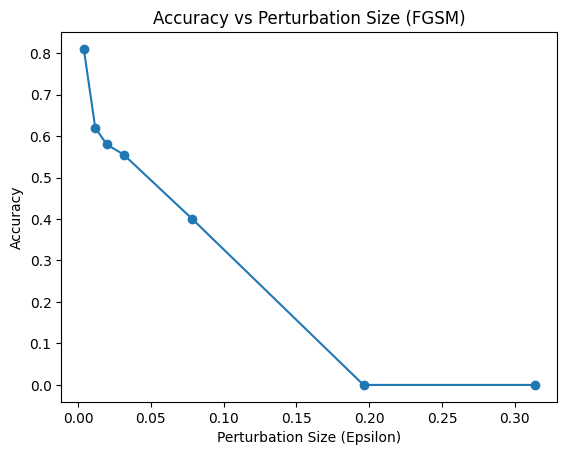

In [ ]:
# Plot accuracy vs perturbation size for FGSM
plt.plot(epsilons, fgsm_accuracies, '-o')
plt.title('Accuracy vs Perturbation Size (FGSM)')
plt.xlabel('Perturbation Size (Epsilon)')
plt.ylabel('Accuracy')
plt.show()

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

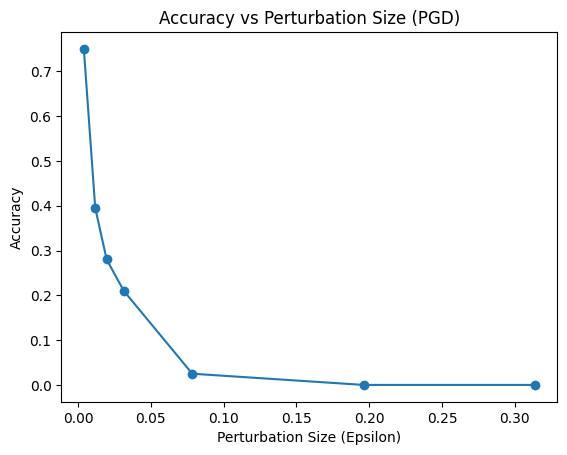

In [ ]:

# Generate adversarial test data using PGD
pgd_accuracies = []
for eps in epsilons:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, norm=np.inf, eps=eps, targeted=False)
    x_test_adv = attack_pgd.generate(test_and_val_images[:200])
    loss_test, accuracy_test = model.evaluate(x_test_adv, test_and_val_labels_onehot[:200])
    pgd_accuracies.append(accuracy_test)

# Plot accuracy vs perturbation size for PGD
plt.plot(epsilons, pgd_accuracies, '-o')
plt.title('Accuracy vs Perturbation Size (PGD)')
plt.xlabel('Perturbation Size (Epsilon)')
plt.ylabel('Accuracy')
plt.show()

# Plot clean test image and adversarial images

In [ ]:
target_label = 7
attack_label = 4

In [ ]:
church_images = []
church_labels = []
for i, label in enumerate(test_and_val_labels):
    if label == 4:
        church_images.append(test_and_val_images[i])
        church_labels.append(label)

In [ ]:
church_images = np.array(church_images)
church_labels_onehot = to_categorical(church_labels, num_classes=10)


In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Run FGSM attacks for different epsilon values
epsilons = [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]
fgsm_church = []
fgsm_gas_pump = []
for eps in epsilons:
    attack_fgsm = FastGradientMethod(estimator=classifier, norm=np.inf, eps=eps, targeted=True, num_random_init=0)
    x_church_adv = attack_fgsm.generate(church_images, y=to_categorical(7*np.ones(len(church_images)), num_classes=10))
    x_church_adv_pred = np.argmax(model.predict(x_church_adv), axis=1)
    x_gas_pump_adv_pred = np.argmax(model.predict(x_church_adv), axis=1)
    fgsm_church.append(np.mean(x_church_adv_pred == 4) * 100)
    fgsm_gas_pump.append(np.mean(x_gas_pump_adv_pred == 7) * 100)


In [ ]:
print('FGSM:')
for eps, church_acc, gas_pump_acc in zip(epsilons, fgsm_church, fgsm_gas_pump):
    print('Epsilon = {:.3f}: Church accuracy = {:.2f}%, Gas pump accuracy = {:.2f}%'.format(eps, church_acc, gas_pump_acc))

FGSM:
Epsilon = 0.004: Church accuracy = 79.46%, Gas pump accuracy = 7.82%
Epsilon = 0.012: Church accuracy = 54.28%, Gas pump accuracy = 13.94%
Epsilon = 0.020: Church accuracy = 50.12%, Gas pump accuracy = 14.67%
Epsilon = 0.031: Church accuracy = 48.17%, Gas pump accuracy = 12.96%
Epsilon = 0.078: Church accuracy = 52.81%, Gas pump accuracy = 7.33%
Epsilon = 0.196: Church accuracy = 22.49%, Gas pump accuracy = 0.24%
Epsilon = 0.314: Church accuracy = 0.24%, Gas pump accuracy = 0.00%


In [ ]:
pgd_church = []
pgd_gas_pump = []
for eps in epsilons:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, norm=np.inf, eps=eps, targeted=True, num_random_init=0)
    x_church_adv = attack_pgd.generate(church_images, y=to_categorical(7*np.ones(len(church_images)), num_classes=10))
    x_church_adv_pred = np.argmax(model.predict(x_church_adv), axis=1)
    x_gas_pump_adv_pred = np.argmax(model.predict(x_church_adv), axis=1)
    pgd_church.append(np.mean(x_church_adv_pred == 4) * 100)
    pgd_gas_pump.append(np.mean(x_gas_pump_adv_pred == 7) * 100)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print('\nPGD:')
for eps, church_acc, gas_pump_acc in zip(epsilons, pgd_church, pgd_gas_pump):
    print('Epsilon = {:.3f}: Church accuracy = {:.2f}%, Gas pump accuracy = {:.2f}%'.format(eps, church_acc, gas_pump_acc))


PGD:
Epsilon = 0.004: Church accuracy = 88.75%, Gas pump accuracy = 7.82%
Epsilon = 0.012: Church accuracy = 73.59%, Gas pump accuracy = 17.11%
Epsilon = 0.020: Church accuracy = 63.57%, Gas pump accuracy = 25.43%
Epsilon = 0.031: Church accuracy = 55.50%, Gas pump accuracy = 27.38%
Epsilon = 0.078: Church accuracy = 21.27%, Gas pump accuracy = 67.97%
Epsilon = 0.196: Church accuracy = 4.40%, Gas pump accuracy = 92.91%
Epsilon = 0.314: Church accuracy = 1.96%, Gas pump accuracy = 97.56%
